In this notebook, we further process continuous variables and compute weight of information value for coarse classing

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/loan_afterEDA.csv', engine='c') #load data after preprocess

# Data preparation

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='good_bad'),  #we drop dependent variable and pass independent variables (x)
                                                    df['good_bad'],               #dependent variables (y)
                                                    test_size=0.2,                #80-20 split
                                                    random_state=42)              #set seed for reproducibility

In [5]:
#We set train and test sets to dummy dataframes, and work
#on this dummy dataframe throughout. In this way, all changes made to dataset
#can be passed to test and train data easily, without much work.

dfx = x_train
dfy = y_train
# dfx = x_test
# dfy = y_test

In [6]:
pd.concat([dfx['grade'], dfy], axis=1)

,grade,good_bad
269056,A,1
499174,B,0
85143,A,1
260335,A,1
338124,B,1
...,...,...
259178,B,1
365838,A,1
131932,B,1
146867,C,1


# Credit Risk Feature Binning and WoE/IV Analysis

The dataset contains many features (e.g., `grade`, `int_rate`, `addr_state`) that need to be evaluated for the target variable `good_bad`. This requires **binning** of the data.

## Fine Classing

Data can be divided into uniform bins, a process called **fine classing**. Typically, we start with a larger number of bins (e.g., 50) to capture detailed risk patterns.

#### Coarse Classing

Often, it is better to **merge bins of similar risk** to maximize predictive power, a process known as **coarse classing**.  

#### Weight of Evidence (WoE)

A useful metric for coarse classing is **Weight of Evidence (WoE)**, which measures the ratio of good to bad borrowers in log scale. For the $i$-th bin:

$$
\mathrm{WoE}_i = \ln \Big( \frac{\mathrm{Good}_i}{\mathrm{Bad}_i} \Big)
$$

- **Positive WoE**: low risk / good borrowers  
- **Negative WoE**: high risk / bad borrowers  

#### Information Value (IV)

**Information Value (IV)** measures the overall predictive power of a variable in the PD model:

$$
\mathrm{IV} = \sum_i (\mathrm{Good}_i - \mathrm{Bad}_i) \times \mathrm{WoE}_i
$$

**IV Interpretation Scale**:

| IV | Predictive Power |
|----|----------------|
| <0.02 | Useless |
| 0.02–0.1 | Weak |
| 0.1–0.3 | Medium |
| 0.3–0.5 | Strong |
| >0.5 | Suspicious / Overfitting |

## Practical Approach

1. Perform **fine classing** (e.g., 50 bins) to compute initial WoE.  
2. Plot WoE and number of observations per bin. Bins with very few observations may produce unreliable WoE.  
3. Merge bins with similar WoE and adequate sample size to perform **coarse classing**, optimizing predictive power while maintaining stability.  


In [65]:
def compute_woe(df, var_name, target_df, categorical=False):
    """
    Compute Weight of Evidence (WoE) and Information Value (IV)
    for a discrete (categorical) variable. Note, for discreet variables, 
    we sort output by increasing WoE.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the feature to be evaluated.
    var_name : str
        Name of the discrete (categorical) variable column.
    target_df : pandas.Series
        Binary target variable where 1 indicates "good" and
        0 indicates "bad".
    """
    df = pd.concat((df[var_name], target_df), axis=1) 

    aggdf = df.groupby(var_name, as_index=False).agg(
        n_obs=(var_name, 'count'),
        n_good=(target_df.name, 'sum'),
    )

    aggdf['n_bad'] = aggdf['n_obs'] - aggdf['n_good']

    smooth_good = aggdf['n_good'] + 0.5
    smooth_bad = aggdf['n_bad'] + 0.5

    aggdf['pct_obs'] = (aggdf['n_obs'] * 100) / aggdf['n_obs'].sum()
    aggdf['pct_good'] = (smooth_good / smooth_good.sum()) * 100
    aggdf['pct_bad'] = (smooth_bad / smooth_bad.sum()) * 100

    aggdf['WoE'] = np.log(aggdf['pct_good'] / aggdf['pct_bad'])
    aggdf['dWoE_abs'] = aggdf['WoE'].diff().abs()
    aggdf['IV'] = np.sum(
        (aggdf['pct_good'] - aggdf['pct_bad']) * aggdf['WoE'] / 100.0
    )
    if categorical:
        aggdf = aggdf.sort_values('WoE').reset_index(drop=True)
    return aggdf


def plot_by_woe(df, rotation_xlabel=0, show_obs=False):
    """
    Plot Weight of Evidence (WoE) by category.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame produced by `woe_discreet`, where the first column
        contains category labels and a column named 'WoE' exists.
    rotation_xlabel : int, optional
        Rotation angle for x-axis labels (default is 0).
    show_obs : bool, optional
        If True, overlays a bar plot showing the percentage of
        observations per category (default is False).
    """
    x = np.array(df.iloc[:, 0].apply(str))
    y = np.array(df['WoE'])
    y_nobs = np.array(df['pct_obs'])

    fig, ax1 = plt.subplots(figsize=(18, 6))
    ax1.plot(x, y, 'bo-', lw=2, ms=10)
    ax1.axhline(0, ls='--', c='k')
    ax1.set_xlabel(df.columns[0])
    ax1.set_ylabel('Weight of Evidence (WoE)')
    ax1.tick_params(axis='x', rotation=rotation_xlabel)

    if show_obs:
        ax2 = ax1.twinx()
        ax2.bar(x, y_nobs, alpha=0.3, color='gray')
        ax2.set_ylabel('Pct of Observations')

`grade`

In [68]:
df_woe = compute_woe(dfx, 'grade', dfy, categorical=True)
df_woe

,grade,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,F,2647,2509,138,0.66175,0.635712,2.636840,-1.422591,0.461410,0.518308
1,G,576,552,24,0.14400,0.139960,0.466445,-1.203780,0.218812,0.518308
2,E,15480,14960,520,3.87000,3.789824,9.909567,-0.961181,0.279363,0.518308
3,D,55992,54557,1435,13.99800,13.820615,27.329843,-0.681818,0.444601,0.518308
4,C,102452,100753,1699,25.61300,25.523078,32.356021,-0.237217,0.566377,0.518308
5,B,113939,112859,1080,28.48475,28.589794,20.571157,0.329160,1.078469,0.518308
6,A,108914,108561,353,27.22850,27.501016,6.730129,1.407629,NaN,0.518308


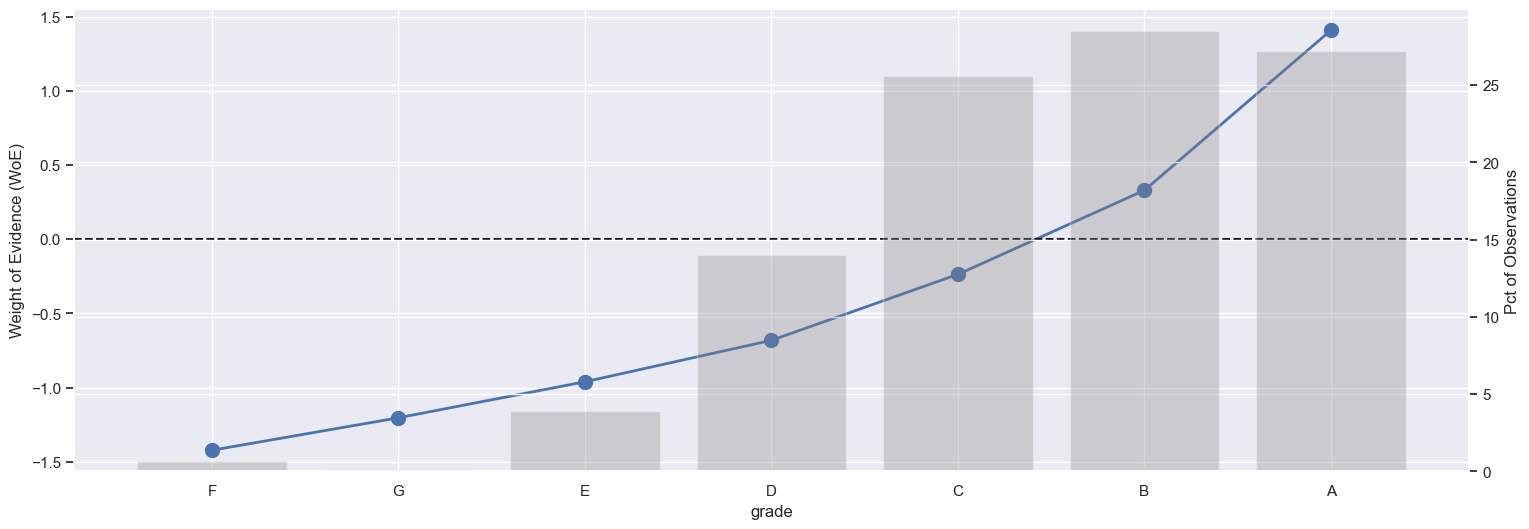

In [69]:
plot_by_woe(df_woe, show_obs=True)

In [70]:
dfx['grade:F_G'] = dfx['grade:F'] | dfx['grade:G']

`home_ownership`

In [71]:
df_woe = compute_woe(dfx, 'home_ownership', dfy, categorical=True)
df_woe

,home_ownership,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,RENT,157781,155353,2428,39.44525,39.354609,46.248334,-0.161412,0.072159,0.026729
1,OWN,48655,47958,697,12.16375,12.148989,13.283184,-0.089253,0.270784,0.026729
2,ANY,392,387,5,0.09800,0.098163,0.104742,-0.064874,NaN,0.026729
3,MORTGAGE,193172,191053,2119,48.29300,48.398239,40.363740,0.181532,0.246406,0.026729


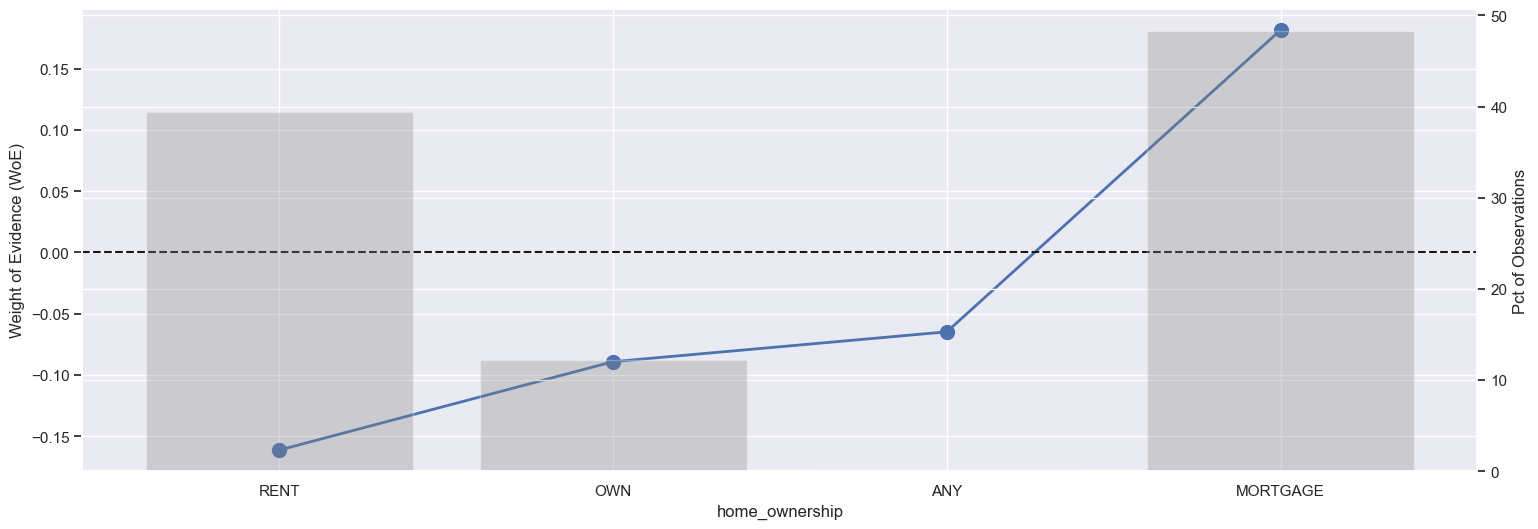

In [72]:
plot_by_woe(df_woe, show_obs=True)

In [73]:
dfx['home_ownership:OWN_ANY'] = dfx['home_ownership:OWN'] | dfx['home_ownership:ANY']

`addr_state`

In [74]:
df_woe = compute_woe(dfx, 'addr_state', dfy, categorical=True)
df_woe

,addr_state,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,HI,1672,1642,30,0.41800,0.416059,0.578309,-0.329281,0.475451,0.038042
1,MS,2506,2462,44,0.62650,0.623771,0.843762,-0.302086,0.313896,0.038042
2,OK,3737,3673,64,0.93425,0.930528,1.222981,-0.273294,0.703009,0.038042
3,AL,4513,4437,76,1.12825,1.124055,1.450512,-0.254974,0.670366,0.038042
4,FL,30190,29682,508,7.54750,7.518821,9.641638,-0.248682,1.288451,0.038042
5,NY,31959,31459,500,7.98975,7.968949,9.489951,-0.174681,0.051039,0.038042
6,SD,808,796,12,0.20200,0.201760,0.237012,-0.161031,0.444732,0.038042
7,NM,2086,2055,31,0.52150,0.520675,0.597270,-0.137243,0.269828,0.038042
8,NV,6143,6052,91,1.53575,1.533148,1.734926,-0.123642,0.013601,0.038042
9,MD,9812,9667,145,2.45300,2.448857,2.758817,-0.119180,0.124703,0.038042


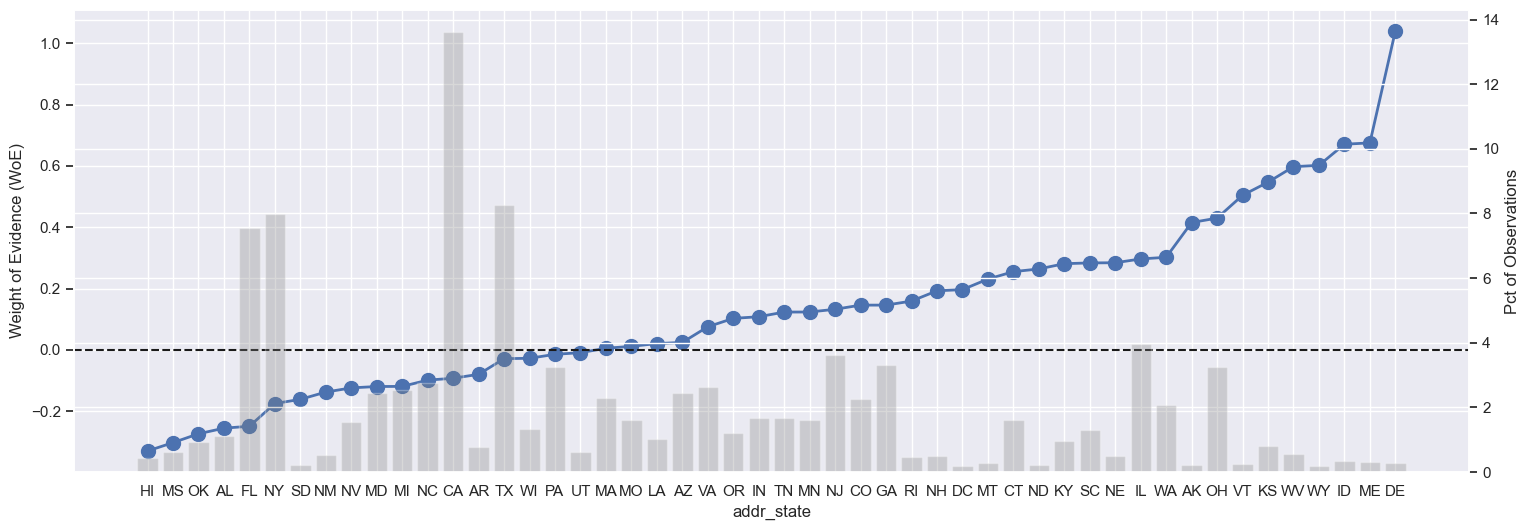

In [75]:
plot_by_woe(df_woe, show_obs=True)

- HI,MS,OK,AL
- NY, FL
- NM, SD, NV-
- MD, MI, NC
- CA
- AR
- TX
- WI, PA, UT, MA, MO, AZ, LA
- VA, OR, IN, TN, MN, NJ, GA, CO
- RI, NH, DC, CT, MT, SC, KY
- IL, WA
- NE, ND
- OH
- AK, KS, VT, WV, WY, ID, ME, DE

In [76]:
# Define groups
state_groups = {
    'addr_state:HI_MS_OK_AL': ['HI', 'MS', 'OK', 'AL'],
    'addr_state:NY_FL': ['NY', 'FL'],
    'addr_state:NM_SD_NV': ['NM', 'SD', 'NV'],
    'addr_state:MD_MI_NC': ['MD', 'MI', 'NC'],
    'addr_state:CA': ['CA'],
    'addr_state:AR': ['AR'],
    'addr_state:TX': ['TX'],
    'addr_state:WI_PA_UT_MA_MO_AZ_LA': ['WI', 'PA', 'UT', 'MA', 'MO', 'AZ', 'LA'],
    'addr_state:VA_OR_IN_TN_MN_NJ_GA_CO': ['VA', 'OR', 'IN', 'TN', 'MN', 'NJ', 'GA', 'CO'],
    'addr_state:RI_NH_DC_CT_MT_SC_KY': ['RI', 'NH', 'DC', 'CT', 'MT', 'SC', 'KY'],
    'addr_state:IL_WA': ['IL', 'WA'],
    'addr_state:NE_ND': ['NE', 'ND'],
    'addr_state:OH': ['OH'],
    'addr_state:AK_KS_VT_WV_WY_ID_ME_DE': ['AK', 'KS', 'VT', 'WV', 'WY', 'ID', 'ME', 'DE']
}

# Create new columns
for col_name, states in state_groups.items():
    dfx[col_name] = dfx['addr_state'].isin(states).astype(int)

`verification_status`

In [77]:
df_woe = compute_woe(dfx, 'verification_status', dfy, categorical=True)
df_woe

,verification_status,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,Verified,80303,78770,1533,20.07575,19.954402,29.206742,-0.380950,0.326665,0.074673
1,Source Verified,158611,156415,2196,39.65275,39.623688,41.834111,-0.054285,0.387771,0.074673
2,Not Verified,161086,159566,1520,40.27150,40.421910,28.959147,0.333486,NaN,0.074673


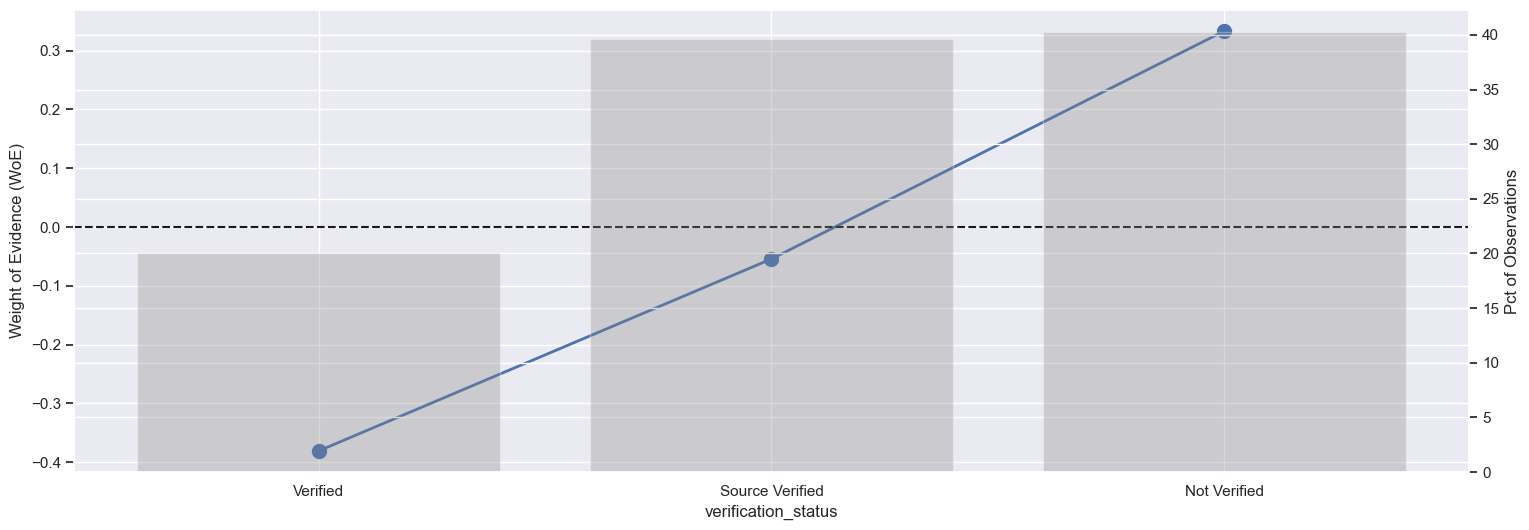

In [78]:
plot_by_woe(df_woe, show_obs=True)

`purpose`

In [80]:
df_woe = compute_woe(dfx, 'purpose', dfy, categorical=True)
df_woe

,purpose,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,wedding,3,3,0,0.00075,0.000887,0.009514,-2.373086,2.304933,0.060292
1,small_business,3714,3610,104,0.92850,0.914612,1.988393,-0.776582,0.344860,0.060292
2,moving,2534,2472,62,0.63350,0.626334,1.189230,-0.641178,0.357888,0.060292
3,renewable_energy,223,219,4,0.05575,0.055604,0.085625,-0.431722,0.063915,0.060292
4,house,4385,4301,84,1.09625,1.089656,1.607839,-0.389029,0.361027,0.060292
5,major_purchase,9431,9253,178,2.35775,2.344097,3.396442,-0.370828,0.018201,0.060292
6,other,28326,27792,534,7.08150,7.040398,10.170298,-0.367807,0.273371,0.060292
7,medical,5383,5290,93,1.34575,1.340190,1.779089,-0.283290,0.087538,0.060292
8,car,4016,3953,63,1.00400,1.001501,1.208258,-0.187680,NaN,0.060292
9,vacation,2810,2771,39,0.70250,0.702077,0.751594,-0.068153,0.708429,0.060292


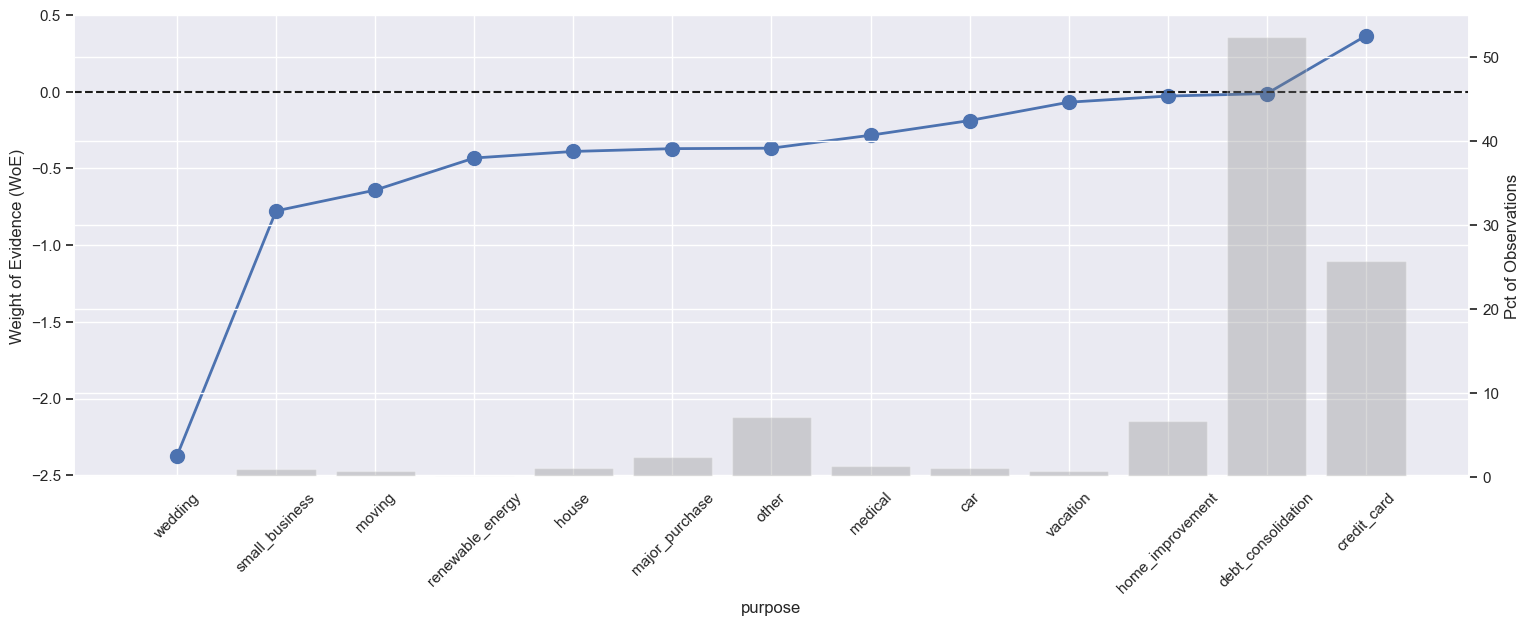

In [81]:
plot_by_woe(df_woe, rotation_xlabel=45, show_obs=True)

- sm_bu, mv
- ho, mjr_prch, oth
- rnw_eng, wed
- med, car
- vac, hm_im
- db_co
- cr_crd

In [82]:
purpose_groups = {
    'purpose:sm_bu_mv': ['small_business', 'moving'],
    'purpose:ho_mjr_prch_oth': ['house', 'major_purchase', 'other'],
    'purpose:rnw_eng_wed': ['renewable_energy', 'wedding'],
    'purpose:med_car': ['medical', 'car'],
    'purpose:vac_hm_im': ['vacation', 'home_improvement'],
    'purpose:db_co': ['debt_consolidation'],
    'purpose:cr_crd': ['credit_card']
}

for col_name, purposes in purpose_groups.items():
    dfx[col_name] = dfx['purpose'].isin(purposes).astype(int)

`initial_list_status`

In [83]:
df_woe = compute_woe(dfx, 'initial_list_status', dfy, categorical=True)
df_woe

,initial_list_status,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,f,55357,54457,900,13.83925,13.79537,17.152381,-0.217804,NaN,0.008645
1,w,344643,340294,4349,86.16075,86.20463,82.847619,0.039721,0.257525,0.008645


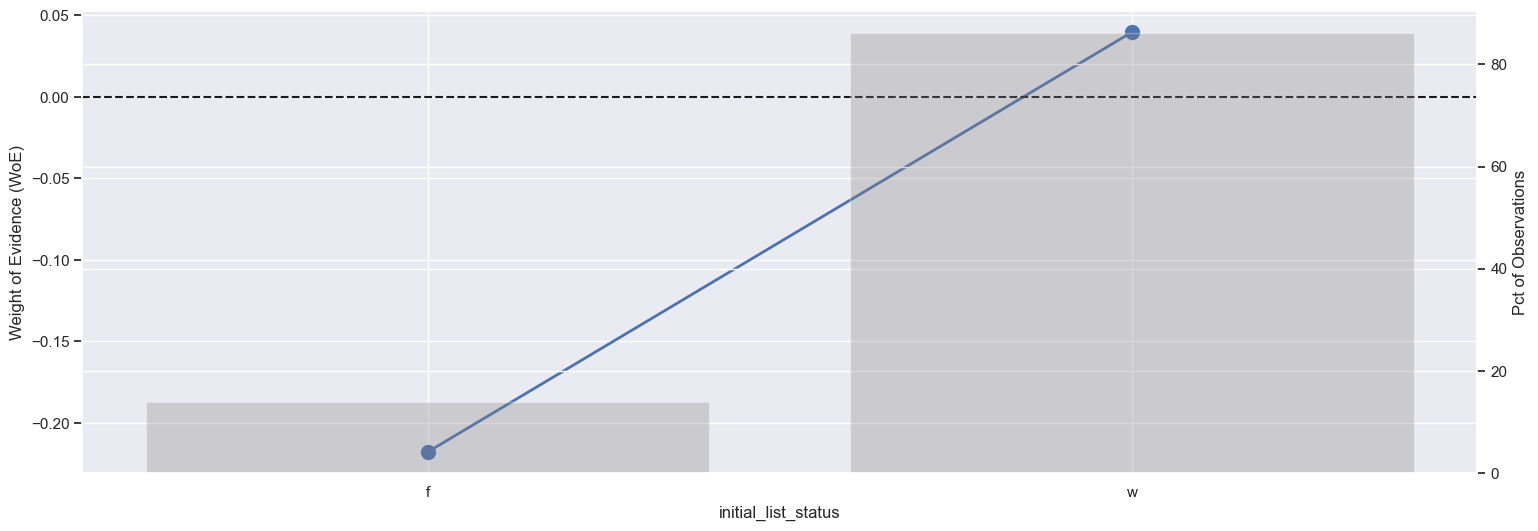

In [84]:
plot_by_woe(df_woe, show_obs=True)

### Continuous varitbales

`term_int`

In [85]:
df_woe = compute_woe(dfx, 'term_int', dfy)
df_woe

,term_int,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,36,278740,275479,3261,69.685,69.78546,62.12381,0.116296,NaN,0.026226
1,60,121260,119272,1988,30.315,30.21454,37.87619,-0.225999,0.342296,0.026226


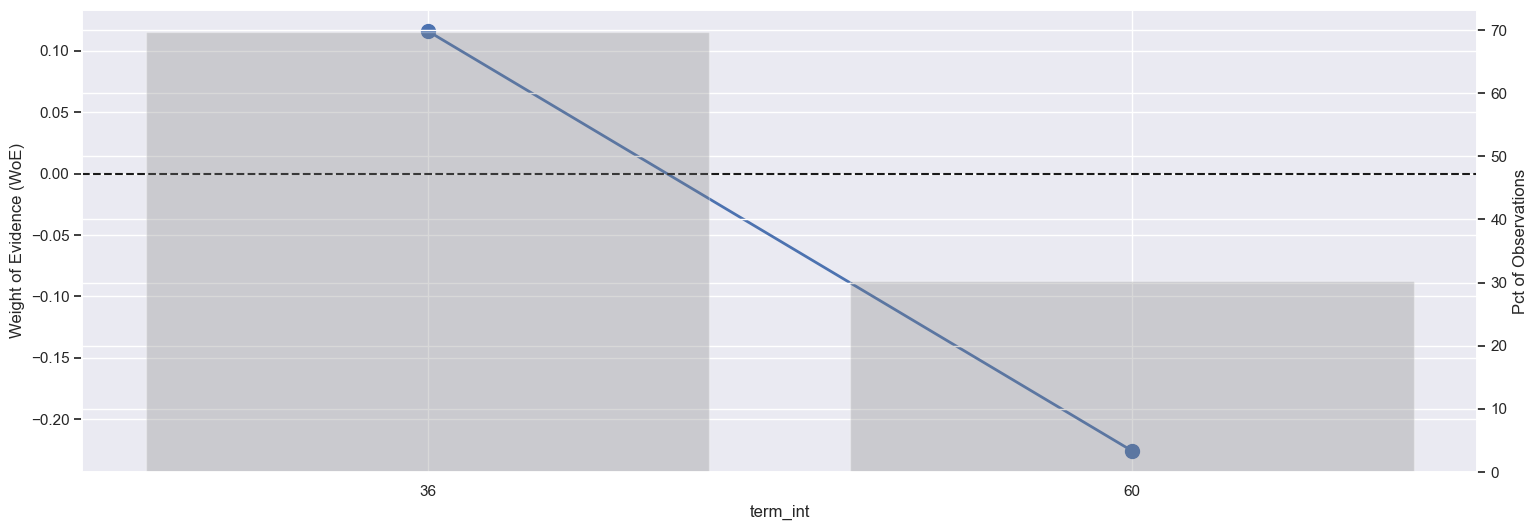

In [86]:
plot_by_woe(df_woe, show_obs=True)

Since `tern_int` is int, we have to turn it into binary

In [87]:
dfx['term:36'] = np.where((dfx['term_int'] == 36), 1, 0)
dfx['term:60'] = np.where((dfx['term_int'] == 60), 1, 0)

`emp_length`

In [88]:
df_woe = compute_woe(dfx, 'emp_length_int', dfy)
df_woe

,emp_length_int,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,0,33909,33348,561,8.47725,8.447866,10.686079,-0.235028,NaN,0.014364
1,1,61977,61115,862,15.49425,15.481822,16.414502,-0.058499,0.176529,0.014364
2,2,36259,35767,492,9.06475,9.060649,9.372918,-0.033884,0.024615,0.014364
3,3,32750,32272,478,8.18750,8.175293,9.106480,-0.107870,0.073986,0.014364
4,4,25263,24902,361,6.31575,6.308319,6.879817,-0.086723,0.021147,0.014364
5,5,24921,24608,313,6.23025,6.233843,5.966315,0.043864,0.130586,0.014364
6,6,17685,17468,217,4.42125,4.425133,4.139309,0.066771,0.022908,0.014364
7,7,14467,14285,182,3.61675,3.618813,3.473213,0.041066,0.025706,0.014364
8,8,13049,12864,185,3.26225,3.258844,3.530307,-0.080012,0.121078,0.014364
9,9,10227,10109,118,2.55675,2.560946,2.255210,0.127134,0.207146,0.014364


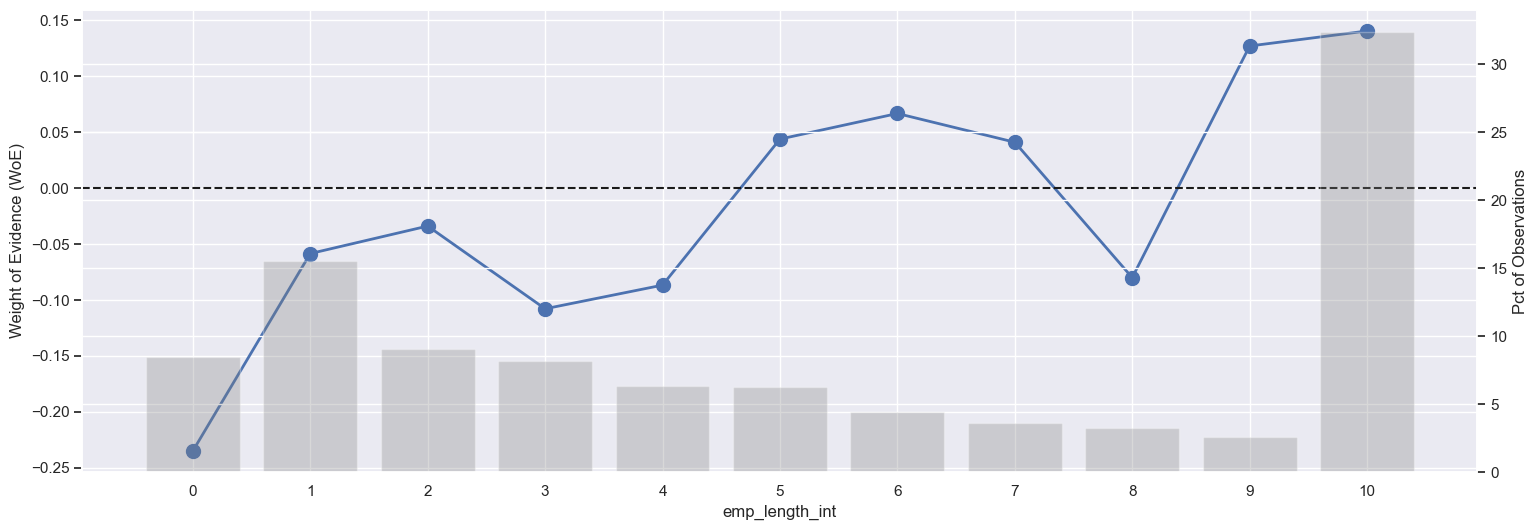

In [89]:
plot_by_woe(df_woe, show_obs=True)

- 0
- 1, 2, 3, 4
- 5, 6, 7
- 8, 9
- 10

In [90]:
dfx['emp_length:0'] = np.where(dfx['emp_length_int'].isin([0]), 1, 0)
dfx['emp_length:1_2_3_4'] = np.where(dfx['emp_length_int'].isin([1,2,3,4]), 1, 0)
dfx['emp_length:5_6_7'] = np.where(dfx['emp_length_int'].isin([5,6,7]), 1, 0)
dfx['emp_length:8_9'] = np.where(dfx['emp_length_int'].isin([8,9]), 1, 0)
dfx['emp_length:10'] = np.where(dfx['emp_length_int'].isin([10]), 1, 0)

`mths_since_earliest_cr_line`

This is a continuous variable. So first we perform fine classing for 50 bins, and later check WoE to merge those bins

In [91]:
dfx['mths_since_earliest_cr_line'].unique()

array([101.,  45., 150., 137., 312., 122., 403., 172., 121., 132., 120.,
        91., 323., 168., 184., 146., 127., 128., 163.,  63., 297.,  31.,
        19., 126., 283.,  20., 330., 140.,  56., 222., 214.,  77., 238.,
       215., 244., 131., 143., 265.,  23., 129., 107., 230., 160., 221.,
        95., 115., 274.,  14.,  86., 389., 148., 374., 192., 237.,  32.,
       185., 170., 104., 314., 361., 130.,  26., 182., 153., 125., 180.,
       145., 136., 188.,  49., 135., 287.,  60., 304., 152., 123., 110.,
        40., 119., 210., 249.,  52., 117.,  18.,  38.,  27., 335., 288.,
        64., 202., 294., 204., 227., 211., 203., 326., 154., 190.,  10.,
       207., 196., 169.,  85.,  67., 151., 142., 139., 155., 100., 270.,
        66.,  59., 216., 113., 171., 412., 201., 149., 258., 199., 234.,
       347., 273., 174., 144., 205., 266., 166., 112., 162., 355., 300.,
        39., 158., 159., 293.,  90.,  83.,  36., 167.,  11., 111., 109.,
       187., 301., 246., 194., 282., 420.,  55., 20

In [92]:
dfx['mths_since_earliest_cr_line_factor'] = pd.cut(dfx['mths_since_earliest_cr_line'], 50) #factor indicates fine classing
dfx['mths_since_earliest_cr_line_factor'] 

269056    (100.24, 116.78]
499174      (34.08, 50.62]
85143      (149.86, 166.4]
260335    (133.32, 149.86]
338124    (298.72, 315.26]
                ...       
259178     (232.56, 249.1]
365838      (83.7, 100.24]
131932      (0.173, 17.54]
146867     (331.8, 348.34]
121958     (149.86, 166.4]
Name: mths_since_earliest_cr_line_factor, Length: 400000, dtype: category
Categories (50, interval[float64, right]): [(0.173, 17.54] < (17.54, 34.08] < (34.08, 50.62] < (50.62, 67.16] ... (761.84, 778.38] < (778.38, 794.92] < (794.92, 811.46] < (811.46, 828.0]]

In [93]:
df_woe = compute_woe(dfx, 'mths_since_earliest_cr_line_factor', dfy)
df_woe

,mths_since_earliest_cr_line_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(0.173, 17.54]",8685,8511,174,2.17125,2.156033,3.308684,-0.428281,NaN,0.025177
1,"(17.54, 34.08]",13624,13417,207,3.40600,3.398763,3.934395,-0.146346,0.281935,0.025177
2,"(34.08, 50.62]",12831,12640,191,3.20775,3.201942,3.631020,-0.125756,0.020590,0.025177
3,"(50.62, 67.16]",17160,16944,216,4.29000,4.292181,4.105044,0.044579,0.170335,0.025177
4,"(67.16, 83.7]",13594,13403,191,3.39850,3.395217,3.631020,-0.067146,0.111725,0.025177
5,"(83.7, 100.24]",26336,25921,415,6.58400,6.566129,7.878271,-0.182184,0.115038,0.025177
6,"(100.24, 116.78]",37197,36682,515,9.29925,9.291978,9.774365,-0.050612,0.131572,0.025177
7,"(116.78, 133.32]",42394,41812,582,10.59850,10.591449,11.044748,-0.041908,0.008704,0.025177
8,"(133.32, 149.86]",36269,35755,514,9.06725,9.057162,9.755404,-0.074266,0.032358,0.025177
9,"(149.86, 166.4]",30743,30353,390,7.68575,7.688791,7.404247,0.037710,0.111975,0.025177


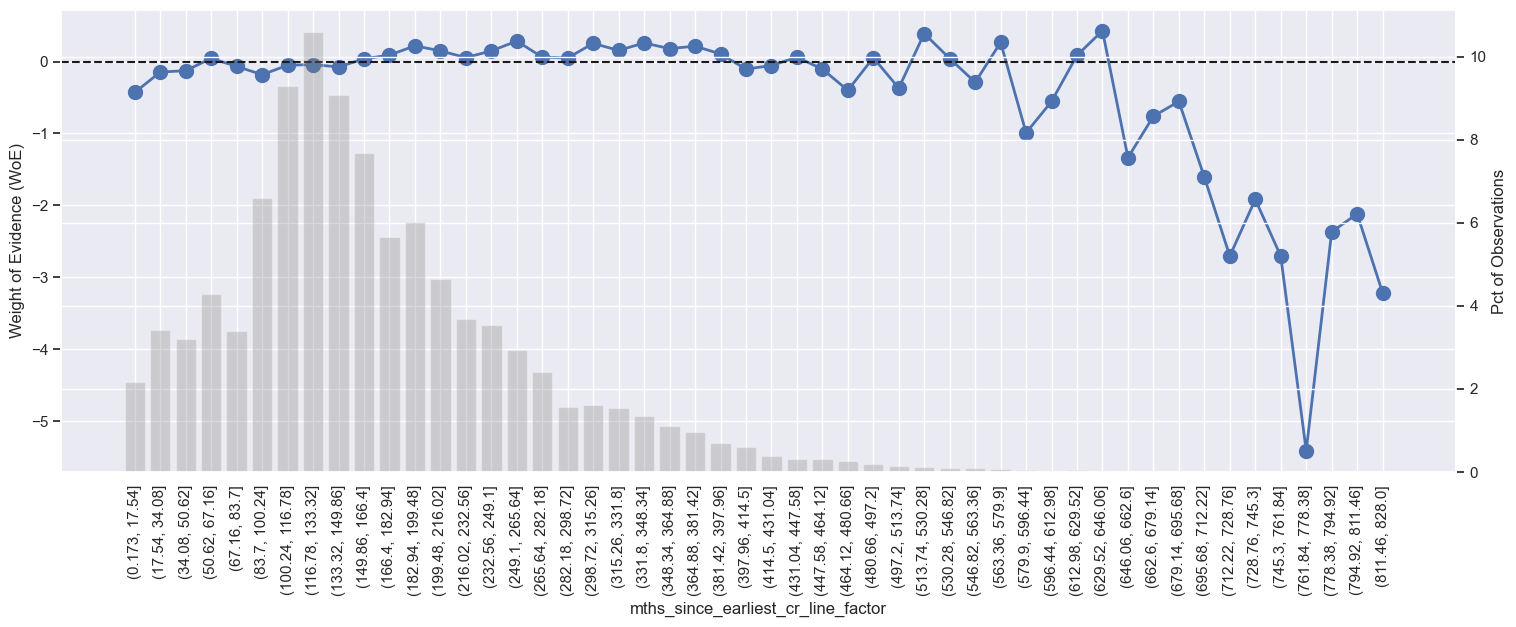

In [94]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

**Note:** We see there is no clear trend or monotonicity in this variable since it fluctutates highly around 0. Therefore, we discard the variable.

`int_rate`

In [95]:
dfx['int_rate_factor'] = pd.cut(dfx['int_rate'], 50)
df_woe = compute_woe(dfx, 'int_rate_factor', dfy)
df_woe 

,int_rate_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(5.284, 5.824]",9063,9048,15,2.26575,2.292062,0.293922,2.053891,NaN,0.590473
1,"(5.824, 6.337]",20036,19992,44,5.00900,5.064271,0.843842,1.792000,0.261891,0.590473
2,"(6.337, 6.851]",20465,20402,63,5.11625,5.168127,1.204134,1.456750,0.335250,0.590473
3,"(6.851, 7.364]",17928,17848,80,4.48200,4.521177,1.526500,1.085795,0.370955,0.590473
4,"(7.364, 7.878]",15446,15399,47,3.86150,3.900825,0.900730,1.465738,0.379943,0.590473
5,"(7.878, 8.392]",14046,13968,78,3.51150,3.538340,1.488575,0.865838,0.599899,0.590473
6,"(8.392, 8.905]",11982,11955,27,2.99550,3.028430,0.521475,1.759138,0.893299,0.590473
7,"(8.905, 9.419]",176,175,1,0.04400,0.044456,0.028444,0.446551,1.312587,0.590473
8,"(9.419, 9.932]",20623,20411,212,5.15575,5.170407,4.029582,0.249289,0.197262,0.590473
9,"(9.932, 10.446]",20728,20560,168,5.18200,5.208150,3.195221,0.488568,0.239280,0.590473


There are not enogh bad data for some bins causing WoE to blow up. So we take 25 bins.

In [96]:
dfx['int_rate_factor'] = pd.cut(dfx['int_rate'], 25)
df_woe = compute_woe(dfx, 'int_rate_factor', dfy)
df_woe 

,int_rate_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(5.284, 6.337]",29099,29040,59,7.27475,7.356430,1.130856,1.872600,NaN,0.527002
1,"(6.337, 7.364]",38393,38250,143,9.59825,9.689472,2.727359,1.267706,0.604893,0.527002
2,"(7.364, 8.392]",29492,29367,125,7.37300,7.439264,2.385251,1.137467,0.130239,0.527002
3,"(8.392, 9.419]",12158,12130,28,3.03950,3.072852,0.541671,1.735703,0.598236,0.527002
4,"(9.419, 10.446]",41351,40971,380,10.33775,10.378746,7.231778,0.361275,1.374428,0.527002
5,"(10.446, 11.473]",35598,35268,330,8.89950,8.934083,6.281479,0.352268,0.009007,0.527002
6,"(11.473, 12.5]",26202,25896,306,6.55050,6.560004,5.825335,0.118775,0.233493,0.527002
7,"(12.5, 13.528]",22847,22546,301,5.71175,5.711394,5.730305,-0.003306,0.122080,0.527002
8,"(13.528, 14.555]",41859,41216,643,10.46475,10.440808,12.230353,-0.158199,0.154893,0.527002
9,"(14.555, 15.582]",20740,20395,345,5.18500,5.166511,6.566568,-0.239794,0.081595,0.527002


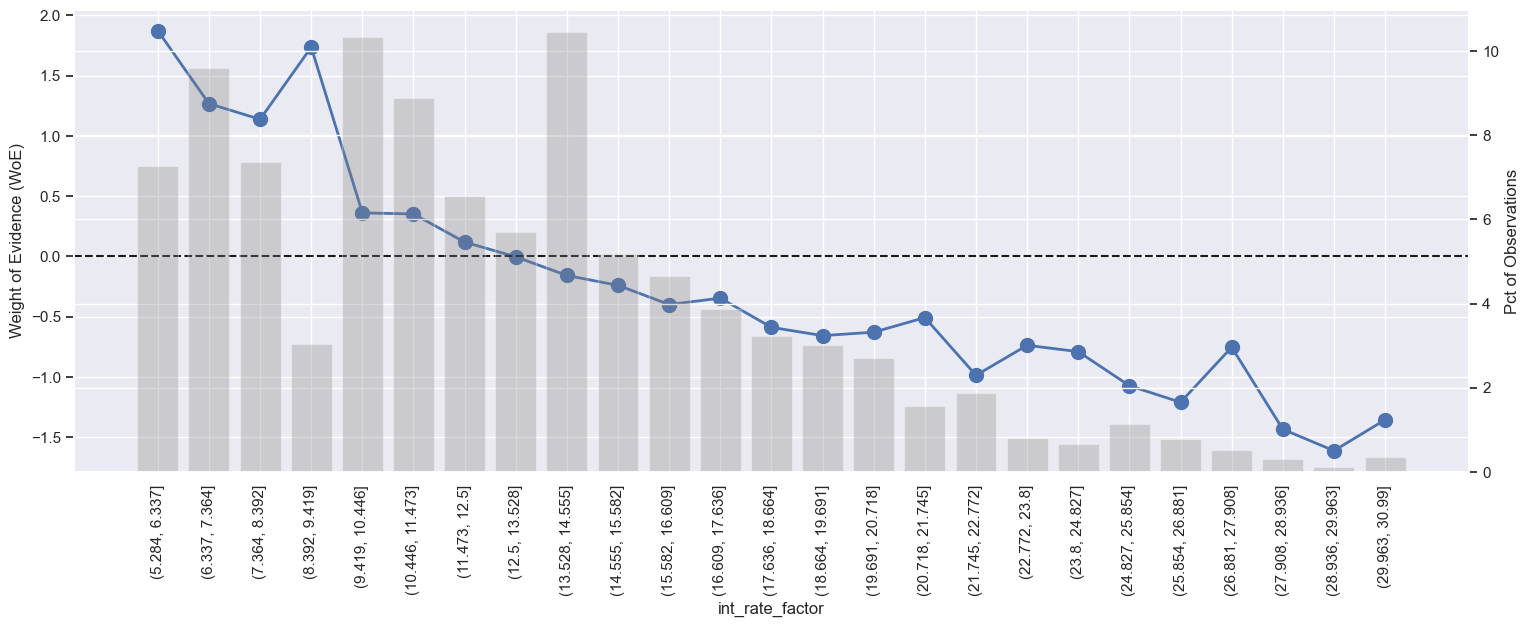

In [97]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

Almost a monotonic trend indicates higher interest rates are likely to deafult

- <9 
- 9-21
- 22-26
- 27-31

In [98]:
dfx['int_rate:<9']   = np.where(dfx['int_rate'] < 9, 1, 0)
dfx['int_rate:9_21'] = np.where((dfx['int_rate'] >= 9) & (dfx['int_rate'] <= 21), 1, 0)
dfx['int_rate:22_26'] = np.where((dfx['int_rate'] >= 22) & (dfx['int_rate'] <= 26), 1, 0)
dfx['int_rate:27_31'] = np.where((dfx['int_rate'] >= 27) & (dfx['int_rate'] <= 31), 1, 0)

`funded_amnt`

In [99]:
dfx['funded_amnt_factor'] = pd.cut(dfx['funded_amnt'], 50)
df_woe = compute_woe(dfx, 'funded_amnt_factor', dfy)
df_woe 

,funded_amnt_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(961.0, 1780.0]",5210,5159,51,1.30250,1.306944,0.976488,0.291484,NaN,0.042183
1,"(1780.0, 2560.0]",7133,7059,74,1.78325,1.788229,1.412590,0.235801,0.055683,0.042183
2,"(2560.0, 3340.0]",8151,8079,72,2.03775,2.046604,1.374668,0.397969,0.162168,0.042183
3,"(3340.0, 4120.0]",10682,10565,117,2.67050,2.676328,2.227911,0.183381,0.214588,0.042183
4,"(4120.0, 4900.0]",5525,5481,44,1.38125,1.388509,0.843762,0.498115,0.314734,0.042183
5,"(4900.0, 5680.0]",21282,21048,234,5.32050,5.331758,4.446341,0.181600,0.316516,0.042183
6,"(5680.0, 6460.0]",15368,15177,191,3.84200,3.844585,3.631020,0.057152,0.124447,0.042183
7,"(6460.0, 7240.0]",11594,11460,134,2.89850,2.903039,2.550246,0.129568,0.072416,0.042183
8,"(7240.0, 8020.0]",16371,16203,168,4.09275,4.104480,3.194918,0.250517,0.120949,0.042183
9,"(8020.0, 8800.0]",4081,4030,51,1.02025,1.020959,0.976488,0.044534,0.205983,0.042183


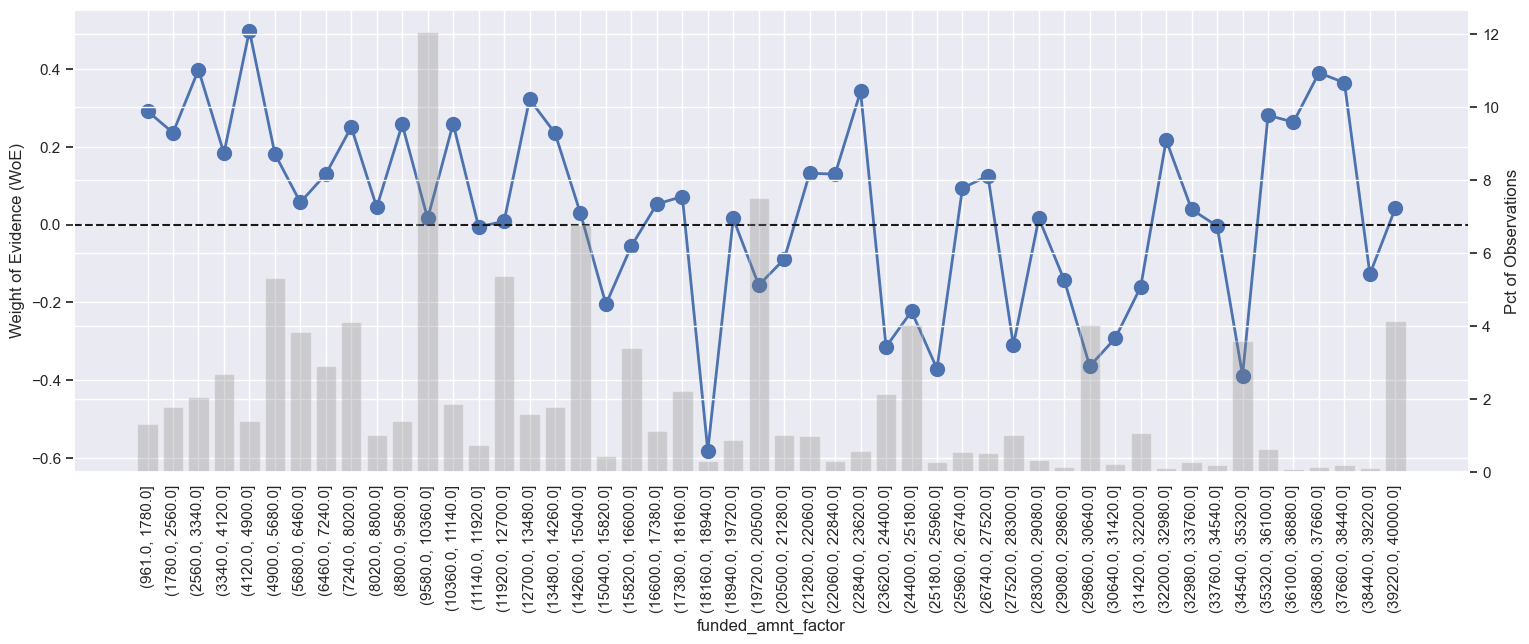

In [100]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

We also discard this due to fluctutation

`annual_inc`

In [101]:
dfx['annual_inc_factor'] = pd.cut(dfx['annual_inc'], 50)
df_woe = compute_woe(dfx, 'annual_inc_factor', dfy)
df_woe 

,annual_inc_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-9757.2, 195144.0]",386591,381465,5126,96.64775,96.629687,97.304736,-0.006962,NaN,0.014716
1,"(195144.0, 390288.0]",11743,11642,101,2.93575,2.949182,1.926545,0.425800,0.432761,0.014716
2,"(390288.0, 585432.0]",1072,1060,12,0.26800,0.268637,0.237259,0.124208,0.301592,0.014716
3,"(585432.0, 780576.0]",285,282,3,0.07125,0.071561,0.066433,0.074357,0.049852,0.014716
4,"(780576.0, 975720.0]",120,119,1,0.03000,0.030271,0.028471,0.061292,0.013064,0.014716
5,"(975720.0, 1170864.0]",58,54,4,0.01450,0.013805,0.085413,-1.822436,1.883728,0.014716
6,"(1170864.0, 1366008.0]",36,36,0,0.00900,0.009246,0.009490,-0.026099,1.796336,0.014716
7,"(1366008.0, 1561152.0]",14,14,0,0.00350,0.003673,0.009490,-0.949263,0.923164,0.014716
8,"(1561152.0, 1756296.0]",8,7,1,0.00200,0.001900,0.028471,-2.707121,1.757858,0.014716
9,"(1756296.0, 1951440.0]",4,4,0,0.00100,0.001140,0.009490,-2.119334,0.587787,0.014716


For annual income, `pct_obs` decreases sharply with more income. This is expected since there are few people with higher incomes, leading to less data. So we conisder $195K to be the threshold for high income, which has a good number of observations. Any income above this will be considered high income.

In [102]:
dfx_temp = dfx.loc[dfx['annual_inc'] <= 195000, :]
dfx_temp['annual_inc_factor'] = pd.cut(dfx_temp['annual_inc'], 50)
df_woe = compute_woe(dfx_temp, 'annual_inc_factor', dfy[dfx_temp.index])
df_woe 

,annual_inc_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-195.0, 3900.0]",1160,1145,15,0.300059,0.300270,0.300912,-0.002137,NaN,0.02065
1,"(3900.0, 7800.0]",398,392,6,0.102951,0.102886,0.126189,-0.204159,0.202022,0.02065
2,"(7800.0, 11700.0]",1312,1288,24,0.339377,0.337755,0.475636,-0.342333,0.138173,0.02065
3,"(11700.0, 15600.0]",2930,2882,48,0.757907,0.755590,0.941565,-0.220044,0.122289,0.02065
4,"(15600.0, 19500.0]",3080,3015,65,0.796708,0.790453,1.271598,-0.475423,0.255379,0.02065
5,"(19500.0, 23400.0]",5697,5601,96,1.473650,1.468322,1.873423,-0.243647,0.231776,0.02065
6,"(23400.0, 27300.0]",9076,8935,141,2.347701,2.342263,2.747039,-0.159406,0.084241,0.02065
7,"(27300.0, 31200.0]",12665,12475,190,3.276072,3.270204,3.698311,-0.123024,0.036382,0.02065
8,"(31200.0, 35100.0]",15327,15089,238,3.964655,3.955412,4.630169,-0.157509,0.034485,0.02065
9,"(35100.0, 39000.0]",12953,12777,176,3.350569,3.349367,3.426519,-0.022774,0.134735,0.02065


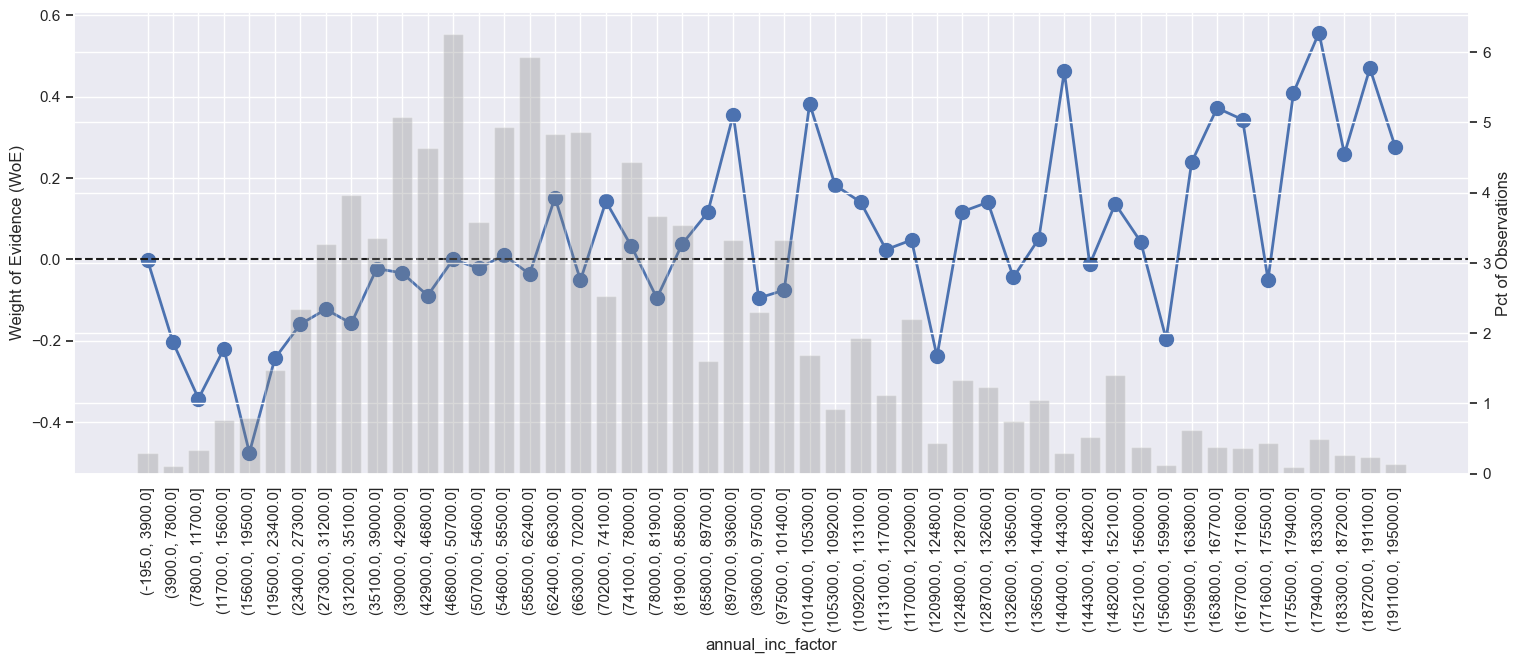

In [103]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

- <15K
- 16K-89K
- 90K-159K
- 160K-195K

In [104]:
dfx['annual_inc:<15K']      = np.where(dfx['annual_inc'] < 15000, 1, 0)
dfx['annual_inc:16K_89K']   = np.where((dfx['annual_inc'] >= 16000) & (dfx['annual_inc'] <= 89000), 1, 0)
dfx['annual_inc:90K_159K']  = np.where((dfx['annual_inc'] >= 90000) & (dfx['annual_inc'] <= 159000), 1, 0)
dfx['annual_inc:160K_195K'] = np.where((dfx['annual_inc'] >= 160000) & (dfx['annual_inc'] <= 195000), 1, 0)

`mths_since_last_delinq`

In [105]:
dfx['mths_since_last_delinq']

269056    17.0
499174     NaN
85143      NaN
260335     NaN
338124     NaN
          ... 
259178     NaN
365838     NaN
131932     NaN
146867    41.0
121958     NaN
Name: mths_since_last_delinq, Length: 400000, dtype: float64

We set 1 if entry  is not NaN

In [106]:
dfx_temp = dfx.loc[pd.notnull(dfx['mths_since_last_delinq'])]
dfx_temp['mths_since_last_delinq_factor'] = pd.cut(dfx_temp['mths_since_last_delinq'], 25)
df_woe = compute_woe(dfx_temp, 'mths_since_last_delinq_factor', dfy[dfx_temp.index])
df_woe 

,mths_since_last_delinq_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-0.226, 9.04]",17622,17315,307,9.959196,9.929267,11.944067,-0.184748,NaN,0.015685
1,"(9.04, 18.08]",25813,25393,420,14.588396,14.561453,16.333269,-0.114826,0.069922,0.015685
2,"(18.08, 27.12]",26737,26351,386,15.110601,15.110801,15.012624,0.006518,0.121345,0.015685
3,"(27.12, 36.16]",24418,24072,346,13.800002,13.803949,13.458924,0.025312,0.018794,0.015685
4,"(36.16, 45.2]",23143,22819,324,13.079427,13.085439,12.604389,0.037455,0.012143,0.015685
5,"(45.2, 54.24]",17389,17161,228,9.827514,9.840959,8.875510,0.103257,0.065802,0.015685
6,"(54.24, 63.28]",14756,14534,222,8.339456,8.334552,8.642455,-0.036277,0.139534,0.015685
7,"(63.28, 72.32]",14439,14255,184,8.160301,8.174564,7.166440,0.131618,0.167895,0.015685
8,"(72.32, 81.36]",11458,11319,139,6.475568,6.490967,5.418528,0.180587,0.048969,0.015685
9,"(81.36, 90.4]",661,656,5,0.373569,0.376458,0.213634,0.566544,0.385957,0.015685


since no of observations decreases sharply for <81, we take values upto this

In [107]:
dfx_temp = dfx.loc[(pd.notnull(dfx['mths_since_last_delinq'])) & 
                   (dfx['mths_since_last_delinq'] < 81)]
dfx_temp['mths_since_last_delinq_factor'] = pd.cut(dfx_temp['mths_since_last_delinq'], 25)
df_woe = compute_woe(dfx_temp, 'mths_since_last_delinq_factor', dfy[dfx_temp.index])
df_woe 

,mths_since_last_delinq_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-0.08, 3.2]",2811,2746,65,1.608657,1.594860,2.561095,-0.473649,NaN,0.021007
1,"(3.2, 6.4]",6932,6815,117,3.966991,3.957679,4.594330,-0.149165,0.324484,0.021007
2,"(6.4, 9.6]",7879,7754,125,4.508933,4.502946,4.907136,-0.085959,0.063206,0.021007
3,"(9.6, 12.8]",8343,8187,156,4.774468,4.754383,6.119257,-0.252374,0.166415,0.021007
4,"(12.8, 16.0]",11658,11467,191,6.671550,6.659040,7.487781,-0.117297,0.135077,0.021007
5,"(16.0, 19.2]",8908,8787,121,5.097801,5.102796,4.750733,0.071490,0.188787,0.021007
6,"(19.2, 22.4]",8890,8759,131,5.087500,5.086537,5.141740,-0.010794,0.082284,0.021007
7,"(22.4, 25.6]",8850,8735,115,5.064610,5.072601,4.516129,0.116198,0.126993,0.021007
8,"(25.6, 28.8]",8758,8620,138,5.011960,5.005821,5.415445,-0.078653,0.194852,0.021007
9,"(28.8, 32.0]",11105,10950,155,6.355083,6.358825,6.080156,0.044813,0.123467,0.021007


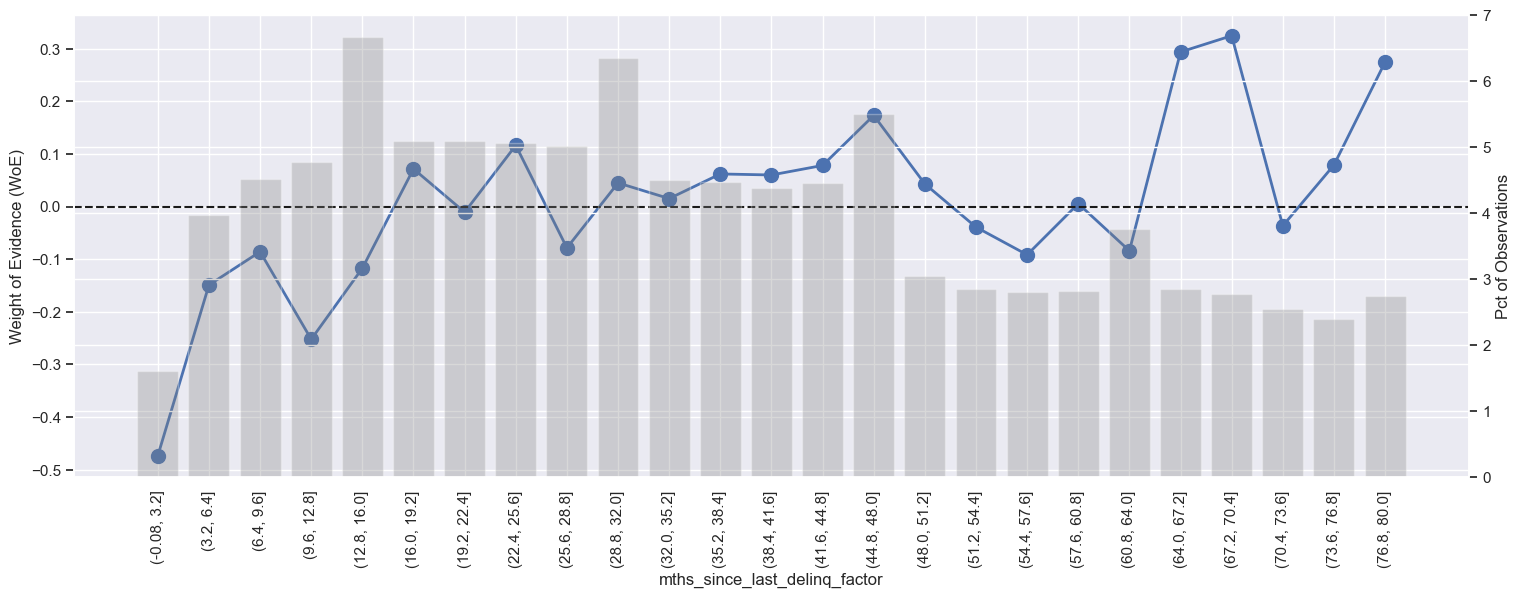

In [108]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

- <3
- 3-16
- 17-48
- 48-64
- 65-70
- 70-80

In [109]:
dfx['mths_since_last_delinq:<3']    = np.where(dfx['mths_since_last_delinq'] <= 3, 1, 0)
dfx['mths_since_last_delinq:3_16']  = np.where((dfx['mths_since_last_delinq'] > 3) & (dfx['mths_since_last_delinq'] <= 16), 1, 0)
dfx['mths_since_last_delinq:17_48'] = np.where((dfx['mths_since_last_delinq'] >= 17) & (dfx['mths_since_last_delinq'] <= 48), 1, 0)
dfx['mths_since_last_delinq:48_64'] = np.where((dfx['mths_since_last_delinq'] > 48) & (dfx['mths_since_last_delinq'] <= 64), 1, 0)
dfx['mths_since_last_delinq:65_70'] = np.where((dfx['mths_since_last_delinq'] >= 65) & (dfx['mths_since_last_delinq'] <= 70), 1, 0)
dfx['mths_since_last_delinq:70_80'] = np.where((dfx['mths_since_last_delinq'] > 70) & (dfx['mths_since_last_delinq'] < 81), 1, 0)

`mths_since_last_record`

In [110]:
dfx['mths_since_last_record']

269056    118.0
499174      NaN
85143       NaN
260335     93.0
338124      NaN
          ...  
259178      NaN
365838      NaN
131932      NaN
146867      NaN
121958      NaN
Name: mths_since_last_record, Length: 400000, dtype: float64

In [114]:
dfx_temp = dfx.loc[pd.notnull(dfx['mths_since_last_record'])]
dfx_temp['mths_since_last_record_factor'] = pd.cut(dfx_temp['mths_since_last_record'], 25)
df_woe = compute_woe(dfx_temp, 'mths_since_last_record_factor', dfy[dfx_temp.index])
df_woe 

,mths_since_last_record_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(0.874, 6.04]",61,60,1,0.119292,0.120134,0.187617,-0.445798,NaN,0.033713
1,"(6.04, 11.08]",141,137,4,0.275741,0.273031,0.562852,-0.723429,0.277632,0.033713
2,"(11.08, 16.12]",170,168,2,0.332453,0.334588,0.312695,0.067669,0.791098,0.033713
3,"(16.12, 21.16]",240,235,5,0.469346,0.467628,0.687930,-0.386013,0.453682,0.033713
4,"(21.16, 26.2]",318,310,8,0.621883,0.616555,1.063164,-0.544858,0.158845,0.033713
5,"(26.2, 31.24]",459,452,7,0.897624,0.898522,0.938086,-0.043091,0.501767,0.033713
6,"(31.24, 36.28]",664,647,17,1.298524,1.285730,2.188868,-0.532058,0.488967,0.033713
7,"(36.28, 41.32]",843,827,16,1.648577,1.643153,2.063790,-0.227927,0.304131,0.033713
8,"(41.32, 46.36]",1151,1131,20,2.250904,2.246801,2.564103,-0.132101,0.095826,0.033713
9,"(46.36, 51.4]",1470,1442,28,2.874743,2.864348,3.564728,-0.218747,0.086646,0.033713


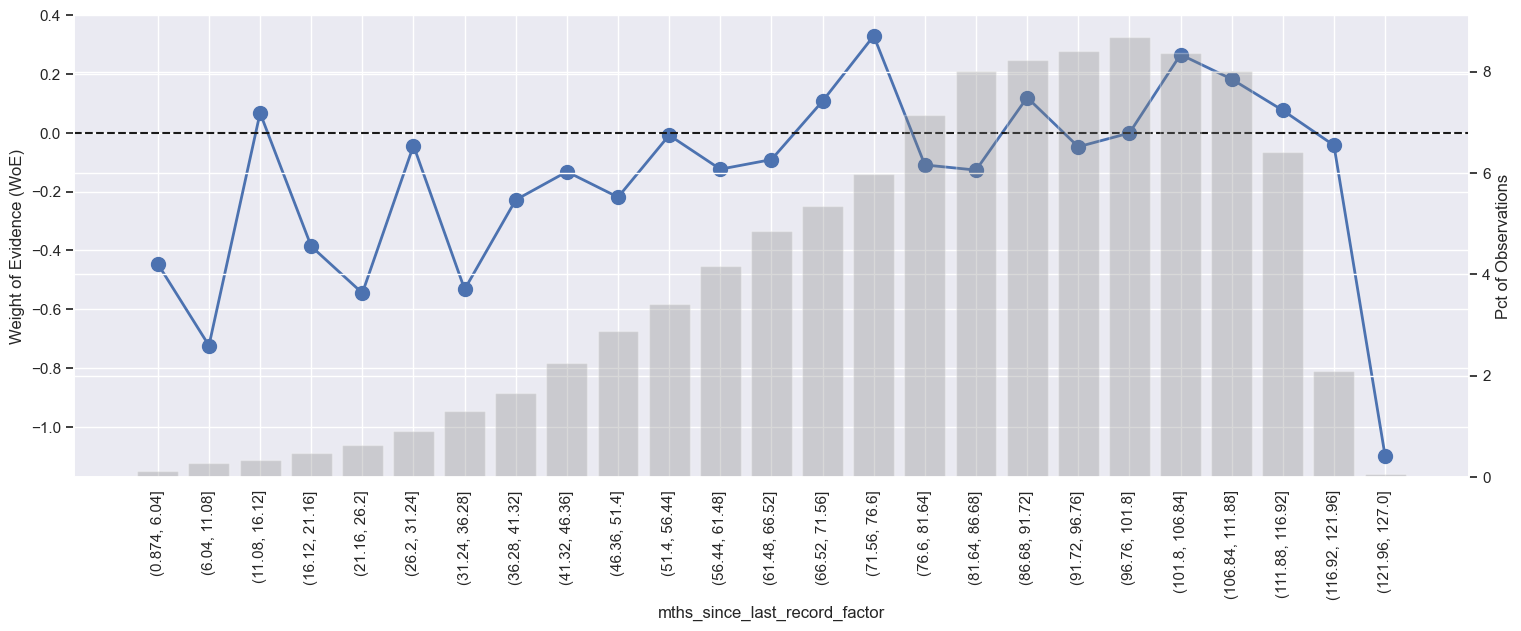

In [115]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True)

- <36
- 37-66
- 67-121
- 122-127

In [107]:
dfx['mths_since_last_record:<36']     = np.where(dfx['mths_since_last_record'] < 36, 1, 0)
dfx['mths_since_last_record:37_66']   = np.where((dfx['mths_since_last_record'] > 36) & (dfx['mths_since_last_record'] <= 66), 1, 0)
dfx['mths_since_last_record:67_121']  = np.where((dfx['mths_since_last_record'] > 66) & (dfx['mths_since_last_record'] <= 121), 1, 0)
dfx['mths_since_last_record:122_127'] = np.where((dfx['mths_since_last_record'] > 121) & (dfx['mths_since_last_record'] <= 127), 1, 0)

`dti`

In [112]:
dfx['dti_factor'] = pd.cut(dfx['dti'], 50)
df_woe = compute_woe(dfx, 'dti_factor', dfy)
df_woe 

,dti_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-0.999, 19.98]",235123,232122,3001,58.78075,58.798906,56.938253,0.032156,NaN,0.010568
1,"(19.98, 39.96]",153028,150972,2056,38.25700,38.242815,39.011667,-0.019905,0.052061,0.010568
2,"(39.96, 59.94]",7811,7692,119,1.95275,1.948586,2.266907,-0.151312,0.131407,0.010568
3,"(59.94, 79.92]",2010,1970,40,0.50250,0.499147,0.768282,-0.431257,0.279944,0.010568
4,"(79.92, 99.9]",773,757,16,0.19325,0.191882,0.313004,-0.489334,0.058077,0.010568
5,"(99.9, 119.88]",325,321,4,0.08125,0.081439,0.085365,-0.047077,0.442257,0.010568
6,"(119.88, 139.86]",211,210,1,0.05275,0.053322,0.028455,0.628023,0.675100,0.010568
7,"(139.86, 159.84]",144,143,1,0.03600,0.036350,0.028455,0.244873,0.383151,0.010568
8,"(159.84, 179.82]",83,80,3,0.02075,0.020391,0.066395,-1.180503,1.425376,0.010568
9,"(179.82, 199.8]",73,71,2,0.01825,0.018112,0.047425,-0.962591,0.217913,0.010568


In [109]:
dfx_temp = dfx.loc[dfx['dti'] <= 40, :] #temp dataframe with lot of observations
dfx_temp['dti_factor'] = pd.cut(dfx_temp['dti'], 25) #fine classing
df_woe = compute_woe(dfx_temp, 'dti_factor', dfy[dfx_temp.index]) #check WoE
df_woe 

,dti_factor,n_obs,n_good,n_bad,pct_obs,pct_good,pct_bad,WoE,dWoE_abs,IV
0,"(-0.04, 1.6]",1599,1573,26,1.647995,1.642734,2.044025,-0.218559,NaN,0.026483
1,"(1.6, 3.2]",1991,1952,39,2.052006,2.038536,3.066038,-0.408154,0.189595,0.026483
2,"(3.2, 4.8]",2733,2701,32,2.816742,2.820740,2.515723,0.114439,0.522593,0.026483
3,"(4.8, 6.4]",3372,3328,44,3.475321,3.475537,3.459119,0.004735,0.109704,0.026483
4,"(6.4, 8.0]",4133,4089,44,4.259639,4.270273,3.459119,0.210664,0.205929,0.026483
5,"(8.0, 9.6]",4886,4825,61,5.035712,5.038901,4.795597,0.049490,0.161174,0.026483
6,"(9.6, 11.2]",5601,5526,75,5.772620,5.770978,5.896226,-0.021471,0.070961,0.026483
7,"(11.2, 12.8]",6002,5922,80,6.185907,6.184533,6.289308,-0.016800,0.004671,0.026483
8,"(12.8, 14.4]",6417,6352,65,6.613623,6.633596,5.110063,0.260935,0.277735,0.026483
9,"(14.4, 16.0]",6499,6413,86,6.698136,6.697300,6.761006,-0.009467,0.270403,0.026483


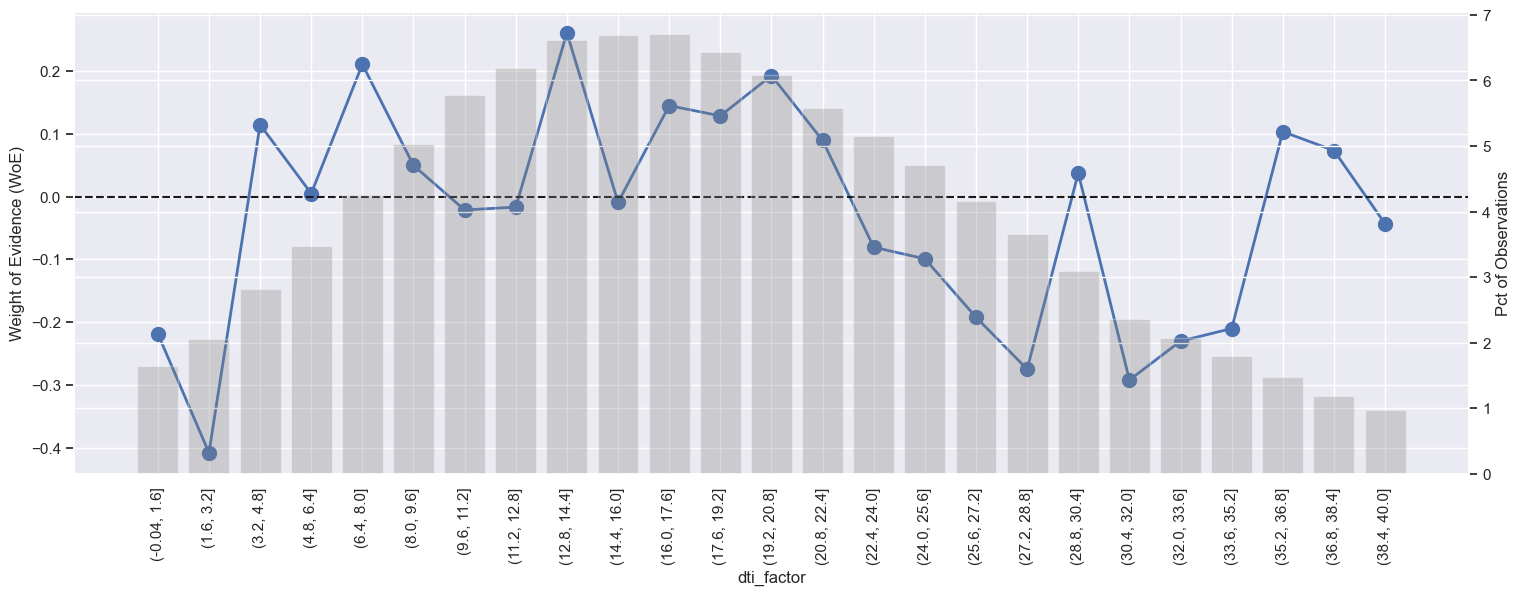

In [ ]:
plot_by_woe(df_woe, rotation_xlabel=90, show_obs=True

- $<1$
- 1-6
- 7-30
- 30-40

In [111]:
dfx['dti:<1']     = np.where(dfx['dti'] < 1, 1, 0)
dfx['dti:1_6']    = np.where((dfx['dti'] >= 1) & (dfx['dti'] <= 6), 1, 0)
dfx['dti:7_30']   = np.where((dfx['dti'] >= 7) & (dfx['dti'] <= 30), 1, 0)
dfx['dti:30_40']  = np.where((dfx['dti'] > 30) & (dfx['dti'] <= 40), 1, 0)

Finally, we save the processed data to csv file. When generating test set everything needs to be same to prevent data leakage

- PS: In any regression model, a categorical variable with k categories must have (k-1) dummy variables to avoid multicollinearity

- Dummy variables of all independent factors are in `data/dummy_variables.txt` 

- Reference variables can be found in `data/dummy_variables_reference.txt` 

In [ ]:
x_train = dfx
x_train.to_csv('data/loan_inputs_train.csv')
y_train = dfy
y_train.to_csv('data/loan_target_train.csv')

# x_test = dfx
# x_test.to_csv('data/loan_inputs_test.csv')
# y_test = dfy
# y_test.to_csv('data/loan_target_test.csv')